## Necessary imports

In [36]:
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import xarray as xr
import cftime
import pandas as pd
import matplotlib.patches as mpatches

## Useful definitions

In [37]:
def AN_map(ds_to_plt, bounds, name, color='bwr_r', lev=100):
    fig, ax = plt.subplots(1, 1, figsize=(10,5),
                           subplot_kw={'projection': ccrs.PlateCarree()})
    fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
    cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
    cdat, clon = cutil.add_cyclic_point(ds_to_plt, coord=ds_to_plt.longitude)
    # cdat = ds_to_plt
    clat = ds_to_plt.latitude
    # clon = ds_to_plt.longitude

    ax.set_title(name)
    lon_ticks = np.arange(bounds[0], bounds[1], 20)
    lat_ticks = np.arange(bounds[2], bounds[3], 10)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cf.LAND)
    
    
    def resize_colobar(event):
        plt.draw()

        posn = ax.get_position()
        cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                              0.04, posn.height])
    
    ax.set_extent(bounds, ccrs.PlateCarree())
    sst_contour = ax.contourf(clon, clat, cdat, levels=lev, transform=ccrs.PlateCarree(), cmap=color, extend='both')
    fig.canvas.mpl_connect('resize_event', resize_colobar)
    ax.coastlines()
    plt.colorbar(sst_contour, cax=cbar_ax)    
    resize_colobar(None)
    # add box for ATL3 index
    ax.add_patch(mpatches.Rectangle(xy=[-20, -3], width=20, height=6,
                                facecolor='none', edgecolor='red',
                                transform=ccrs.PlateCarree())
                )
    plt.savefig(name, dpi=300)
    plt.show()
    
    
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three 
    dimensions (time, lat, lon). 
    Datasets can be provided in any order, but note that the regression slope 
    and intercept will be calculated for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, 
    and standard error on regression between the two datasets along their 
    aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and
    lagy shifting y, with the specified lag amount.
    https://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x, y = xr.align(x, y)

    #2. Add lag information if any, and shift the data accordingly
    if lagx != 0:

        # If x lags y by 1, x must be shifted 1 step backwards. 
        # But as the 'zero-th' value is nonexistant, xr assigns it as invalid 
        # (nan). Hence it needs to be dropped
        x   = x.shift(time=-lagx).dropna(dim='time')

        # Next important step is to re-align the two datasets so that y adjusts
        # to the changed coordinates of x
        x, y = xr.align(x, y)

    if lagy!=0:
        y   = y.shift(time=-lagy).dropna(dim='time')
        x, y = xr.align(x, y)

    #3. Compute data length, mean and standard deviation along time axis: 
    n = y.notnull().sum(dim='time')
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)

    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean) * (y - ymean), axis=0) / n

    #5. Compute correlation along time axis
    cor   = cov / (xstd * ystd)

    #6. Compute regression slope and intercept:
    slope     = cov / (xstd**2)
    intercept = ymean - xmean * slope  

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor * np.sqrt(n-2) / np.sqrt(1 - cor**2)
    stderr = slope / tstats

    from scipy.stats import t
    pval = t.sf(tstats, n-2) * 2
    pval = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov, cor, slope, intercept, pval, stderr


def cyclic_dataarray(da, coord='longitude'):
    """ Add a cyclic coordinate point to a DataArray along a specified
    named coordinate dimension.

    >>> from xray import DataArray
    >>> data = DataArray([[1, 2, 3], [4, 5, 6]],
    ...                      coords={'x': [1, 2], 'y': range(3)},
    ...                      dims=['x', 'y'])
    >>> cd = cyclic_dataarray(data, 'y')
    >>> print cd.data
    array([[1, 2, 3, 1],
           [4, 5, 6, 4]])
    """
    assert isinstance(da, xr.DataArray)

    lon_idx = da.dims.index(coord)
    cyclic_data, cyclic_coord = cutil.add_cyclic_point(da.values,
                                                 coord=da.coords[coord],
                                                 axis=lon_idx)

    # Copy and add the cyclic coordinate and data
    new_coords = dict(da.coords)
    new_coords[coord] = cyclic_coord
    new_values = cyclic_data

    new_da = xr.DataArray(new_values, dims=da.dims, coords=new_coords)

    # Copy the attributes for the re-constructed data and coords
    for att, val in da.attrs.items():
        new_da.attrs[att] = val
    for c in da.coords:
        for att in da.coords[c].attrs:
            new_da.coords[c].attrs[att] = da.coords[c].attrs[att]

    return new_da


def comp_map(ds_to_plt, bounds, name, lev=np.arange(-1,1,0.1)):
    fig, ax = plt.subplots(1, 1, figsize=(10,5),
                           subplot_kw={'projection': ccrs.PlateCarree()})
    fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
    cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
    cdat, clon = cutil.add_cyclic_point(ds_to_plt, coord=ds_to_plt.longitude)
    # cdat = ds_to_plt
    clat = ds_to_plt.latitude
    # clon = ds_to_plt.longitude

    ax.set_title(name)
    lon_ticks = np.arange(bounds[0], bounds[1], 20)
    lat_ticks = np.arange(bounds[2], bounds[3], 10)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cf.LAND)
    
    
    def resize_colobar(event):
        plt.draw()

        posn = ax.get_position()
        cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                              0.04, posn.height])
    
    ax.set_extent(bounds, ccrs.PlateCarree())
    sst_contour = ax.contourf(clon, clat, cdat, levels=lev,
                              transform=ccrs.PlateCarree(), cmap='Spectral_r', extend='both')
    fig.canvas.mpl_connect('resize_event', resize_colobar)
    ax.coastlines()
    plt.colorbar(sst_contour, cax=cbar_ax)    
    resize_colobar(None)
    # add box for ATL3 index
    ax.add_patch(mpatches.Rectangle(xy=[-20, -3], width=20, height=6,
                                facecolor='none', edgecolor='red',
                                transform=ccrs.PlateCarree())
                )
    plt.savefig(name, dpi=300)
    plt.show()
    

def multi_map(ds1, ds2, ds3, ds4, bounds, name, lev=np.arange(-1,1,0.1)):
    fig, axs = plt.subplots(2, 2, figsize=(15,8),
                           subplot_kw={'projection': ccrs.PlateCarree()})
    fig.subplots_adjust(hspace=0.3, wspace=0.1)
    cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
    cdat1, clon = cutil.add_cyclic_point(ds1, coord=ds1.longitude)
    clat = ds1.latitude
    cdat2 = cutil.add_cyclic_point(ds2)
    cdat3 = cutil.add_cyclic_point(ds3)
    cdat4 = cutil.add_cyclic_point(ds4)

    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    lon_ticks = np.arange(bounds[0], bounds[1], 20)
    lat_ticks = np.arange(bounds[2], bounds[3], 10)

    fig.suptitle(name)
    for i in (0, 1):
        for j in (0, 1):
            axs[i, j].set_xticks(lon_ticks, crs=ccrs.PlateCarree())
            axs[i, j].set_yticks(lat_ticks, crs=ccrs.PlateCarree())
            axs[i, j].xaxis.set_major_formatter(lon_formatter)
            axs[i, j].yaxis.set_major_formatter(lat_formatter)
            axs[i, j].add_feature(cf.LAND)
            axs[i, j].set_extent(bounds, ccrs.PlateCarree())
            axs[i, j].coastlines()
    
    
    def resize_colobar(event):
        plt.draw()

        upper = axs[0, 1].get_position()
        lower = axs[1, 1].get_position()
        cbar_ax.set_position([lower.x0 + lower.width + 0.01, lower.y0,
                              0.04, 2 * upper.height])
    
    
    sst_contour = axs[0, 0].contourf(clon, clat, cdat1, levels=lev, transform=ccrs.PlateCarree(), cmap='Spectral_r', extend='both')
    axs[1, 0].contourf(clon, clat, cdat2, levels=lev, transform=ccrs.PlateCarree(), cmap='Spectral_r', extend='both')
    axs[0, 1].contourf(clon, clat, cdat3, levels=lev, transform=ccrs.PlateCarree(), cmap='Spectral_r', extend='both')
    axs[1, 1].contourf(clon, clat, cdat4, levels=lev, transform=ccrs.PlateCarree(), cmap='Spectral_r', extend='both')
    axs[0, 0].set_title('MAM')
    axs[0, 1].set_title('JJA')
    axs[1, 0].set_title('SON')
    axs[1, 1].set_title('DJF')
    fig.canvas.mpl_connect('resize_event', resize_colobar)
    plt.colorbar(sst_contour, cax=cbar_ax)    
    resize_colobar(None)
    # plt.subplots(2, 2, sharex=True, sharey=True)
    # add box for ATL3 index
    for i in (0, 1):
        for j in (0, 1):
            axs[i, j].add_patch(mpatches.Rectangle(xy=[-20, -3], width=20, height=6,
                                facecolor='none', edgecolor='red',
                                transform=ccrs.PlateCarree())
                )
    plt.savefig(name, dpi=300)
    # fig.show()
    
    

## Data Import

In [38]:
GP = xr.load_dataset('Data/GP_results.nc')
PI = xr.load_dataset('Data/PI_results.nc')
AN = xr.load_dataset('Data/AN_Index_results.nc')

In [39]:
# shift -1.25 to 358.75
lons = np.arange(0., 360, 1.25)
GP = GP.assign_coords(longitude=lons).shift(longitude=-1)
PI = PI.assign_coords(longitude=lons).shift(longitude=-1)

In [40]:
# cftime to datetime fix on AN
dates = AN.indexes['time'].to_datetimeindex()
AN = AN.assign_coords(time=dates)

/glade/scratch/acruz/ipykernel_47183/421709906.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dates = AN.indexes['time'].to_datetimeindex()


### check values

In [41]:
GP

<xarray.Dataset>
Dimensions:    (time: 744, latitude: 49, longitude: 288)
Coordinates:
  * time       (time) datetime64[ns] 1958-01-01 1958-02-01 ... 2019-12-01
  * latitude   (latitude) float64 -20.0 -18.75 -17.5 -16.25 ... 37.5 38.75 40.0
  * longitude  (longitude) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    number     int64 0
    step       timedelta64[ns] 00:00:00
Data variables:
    GP         (time, latitude, longitude) float64 nan 0.0006259 ... nan nan

In [42]:
PI

<xarray.Dataset>
Dimensions:    (time: 744, latitude: 49, longitude: 288)
Coordinates:
  * time       (time) datetime64[ns] 1958-01-01 1958-02-01 ... 2019-12-01
  * latitude   (latitude) float64 -20.0 -18.75 -17.5 -16.25 ... 37.5 38.75 40.0
  * longitude  (longitude) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    step       timedelta64[ns] 00:00:00
    number     int64 0
Data variables:
    VMAX       (time, latitude, longitude) float64 nan 10.92 10.37 ... nan nan
    PMIN       (time, latitude, longitude) float64 nan 1.014e+03 ... nan nan
    IFL        (time, latitude, longitude) float64 0.0 1.0 1.0 ... 0.0 0.0 nan
    TO         (time, latitude, longitude) float64 nan 289.2 289.4 ... nan nan
    LNB        (time, latitude, longitude) float64 nan 833.1 842.3 ... nan nan
Attributes:
    Description:  Calculated tropical cyclone potential intensity

In [43]:
AN = AN.sel(latitude=slice(-20, 40))
AN

<xarray.Dataset>
Dimensions:    (month: 12, latitude: 49, longitude: 289, time: 743)
Coordinates:
  * time       (time) datetime64[ns] 1958-02-01 1958-03-01 ... 2019-12-01
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * latitude   (latitude) float64 -20.0 -18.75 -17.5 -16.25 ... 37.5 38.75 40.0
  * longitude  (longitude) float64 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8 360.0
Data variables:
    sst_mean   (month, latitude, longitude) float32 22.63 22.54 ... nan nan
    sst_anom   (time, latitude, longitude) float32 -0.2062 -0.348 ... nan nan
    index      (time) float32 nan -0.5987 -1.085 -1.48 ... 0.9143 1.174 nan
    atln_anom  (latitude, longitude) float32 0.2231 0.1995 0.177 ... nan nan nan
Attributes:
    Description:  Results from ATLN_Index.ipynb script based on HadiSST data.

## Sample Plots

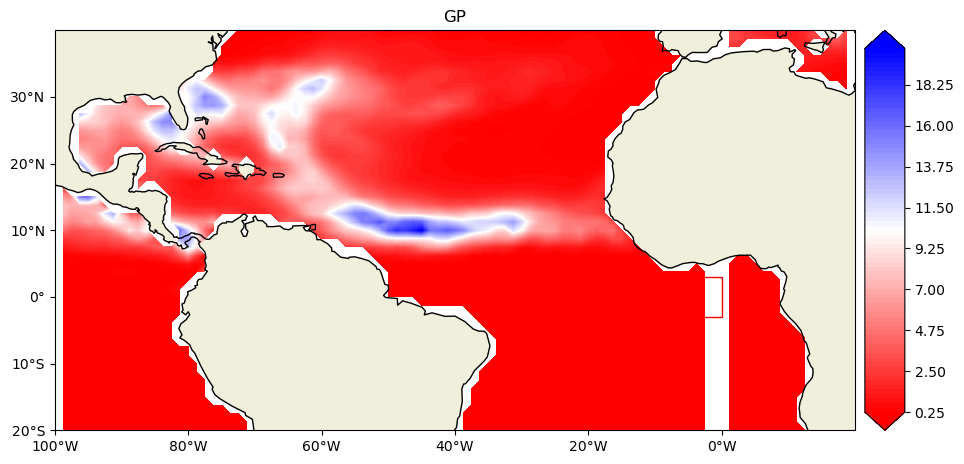

In [44]:
box = [-100, 20, -20, 40]
AN_map(GP.GP[8], box, 'GP')

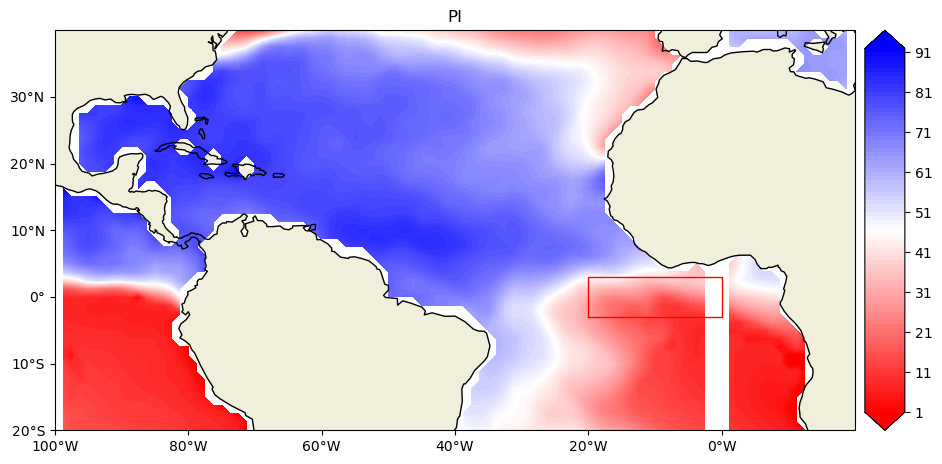

In [45]:
AN_map(PI.VMAX[8], box, 'PI')

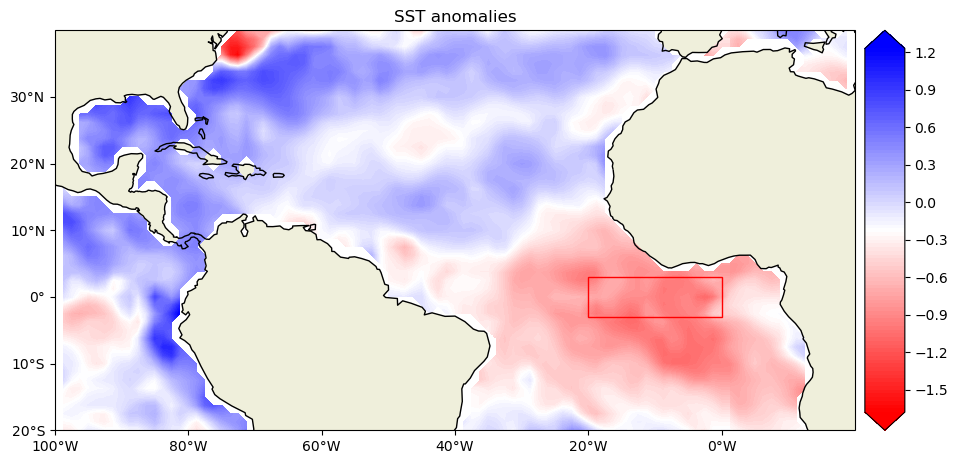

In [46]:
AN_map(AN.sst_anom[8], box, 'SST anomalies')

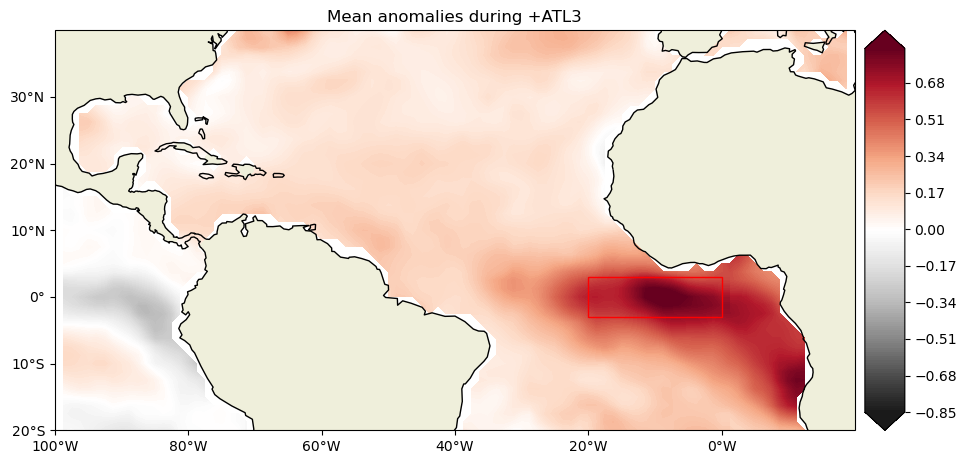

In [47]:
AN_map(AN.atln_anom, box, 'Mean anomalies during +ATL3', color='RdGy_r', lev=np.arange(-0.85, 0.85, 0.01))

# Correlations and Analysis

## full year statistics

#### GP and SST Anom

In [48]:
cov, cor, slope, intercept, pval, stderr = lag_linregress_3D(AN.sst_anom, GP.GP)
GP_SSTANOM = {'cov': cov, 'cor': cor, 'slope': slope, 'intercept': intercept, 'pval': pval, 'stderr':stderr}

/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


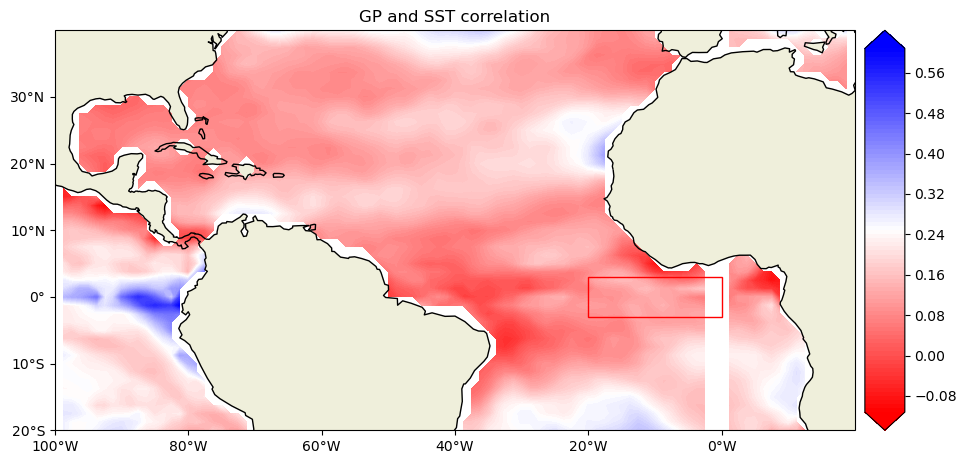

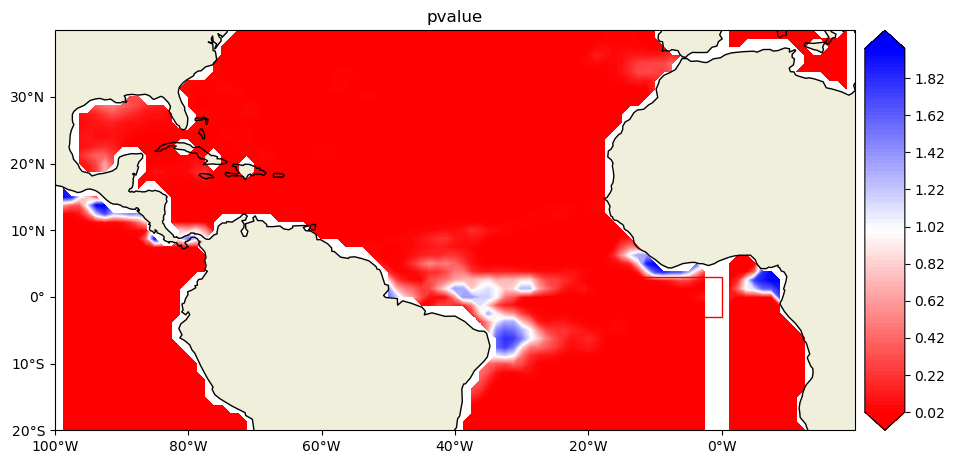

In [49]:
AN_map(GP_SSTANOM['cor'], box, 'GP and SST correlation')
AN_map(GP_SSTANOM['pval'], box, 'pvalue')

### PI and SST anom

In [50]:
cov, cor, slope, intercept, pval, stderr = lag_linregress_3D(AN.sst_anom, PI.VMAX)
PI_SSTA = {'cov': cov, 'cor': cor, 'slope': slope, 'intercept': intercept, 'pval': pval, 'stderr':stderr}

/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


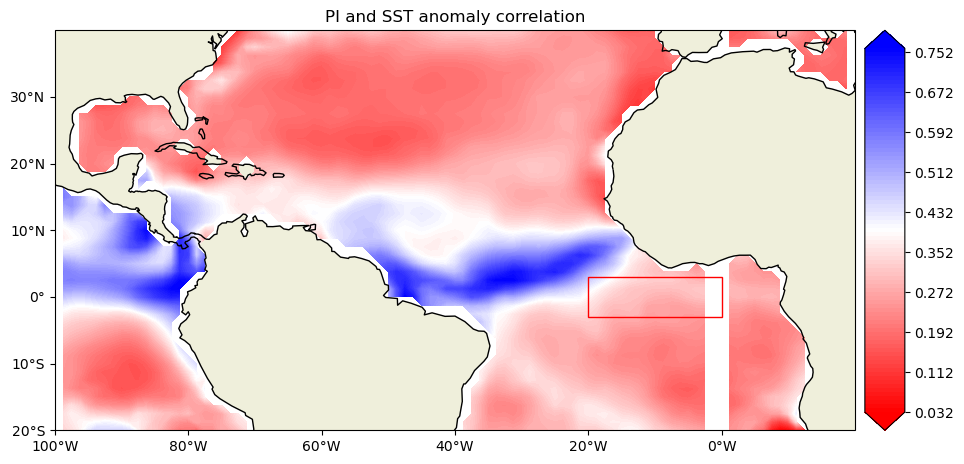

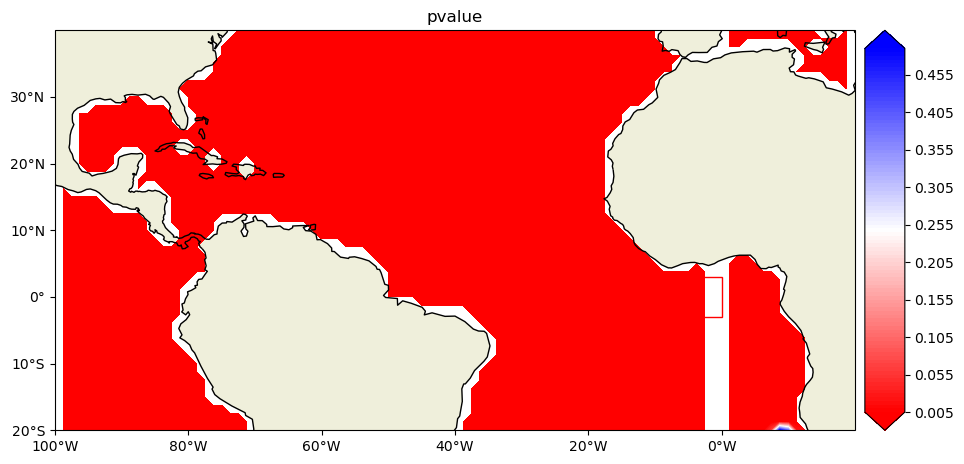

In [51]:
AN_map(PI_SSTA['cor'], box, 'PI and SST anomaly correlation')
AN_map(PI_SSTA['pval'], box, 'pvalue')

## JJA correlations

In [52]:
AN_jja = AN.where(AN["time.season"]=='JJA', drop=True)
GP_jja = GP.where(GP["time.season"]=='JJA', drop=True)
PI_jja = PI.where(PI["time.season"]=='JJA', drop=True)

### GP and SST anomalies

In [53]:
cov, cor, slope, intercept, pval, stderr = lag_linregress_3D(AN_jja.sst_anom, GP_jja.GP)
GP_SSTA_JJA = {'cov': cov, 'cor': cor, 'slope': slope, 'intercept': intercept, 'pval': pval, 'stderr':stderr}

/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


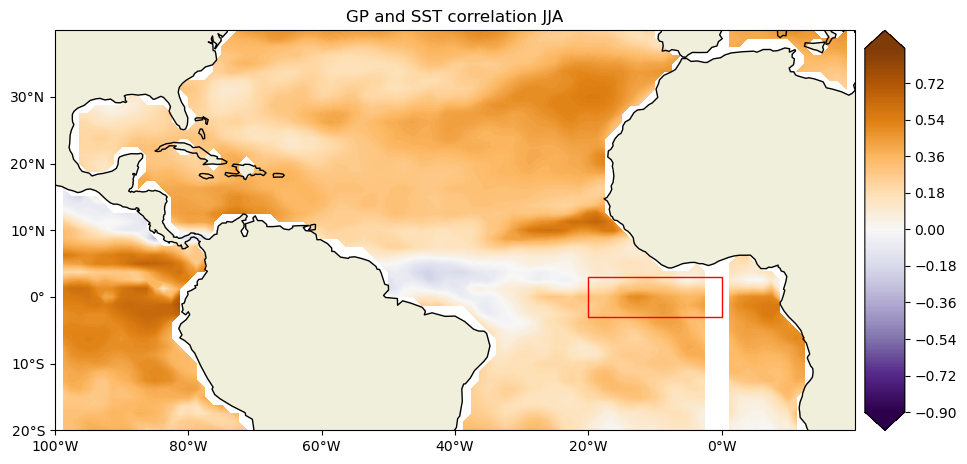

In [54]:
AN_map(GP_SSTA_JJA['cor'], box, 'GP and SST correlation JJA', color='PuOr_r', lev=np.arange(-.9, .9, 0.01))
# AN_map(GP_SSTA_JJA['pval'], box, 'GP and SST pvalue JJA')

### PI and SST anomalies JJA

In [55]:
cov, cor, slope, intercept, pval, stderr = lag_linregress_3D(AN_jja.sst_anom, PI_jja.VMAX)
PI_SSTA = {'cov': cov, 'cor': cor, 'slope': slope, 'intercept': intercept, 'pval': pval, 'stderr':stderr}

/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


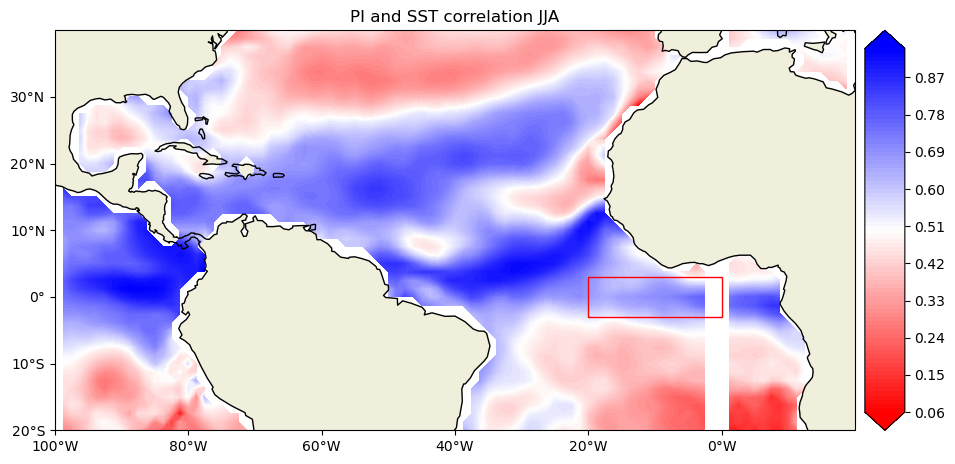

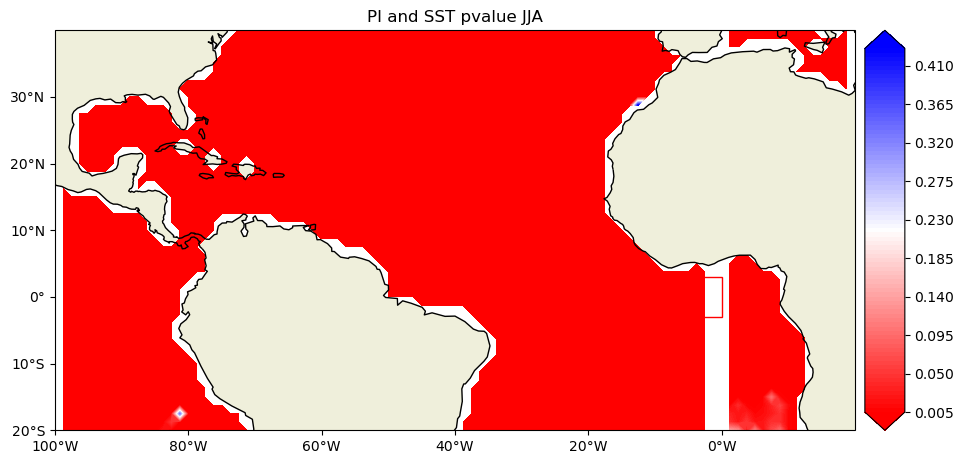

In [56]:
AN_map(PI_SSTA['cor'], box, 'PI and SST correlation JJA')
AN_map(PI_SSTA['pval'], box, 'PI and SST pvalue JJA')

## Difference between mean state and AN phases

In [57]:
# identify AN phase
summer = AN.index.where(AN.index['time.season']=='JJA')
ANoy = AN.index.where(summer >= 0.5, drop=True).time.dt.year
ANay = AN.index.where(summer <=-0.5, drop=True).time.dt.year
ANny = AN.index.time.dt.year
ANoy, ANoy_counts = np.unique(ANoy, return_counts=True)
ANay, ANay_counts = np.unique(ANay, return_counts=True)

# correction to take only when the three months go over the threshold
ANoy = ANoy[ANoy_counts == 3]
ANay = ANay[ANay_counts == 3] 
ANny = np.setdiff1d(ANny, ANoy)
ANny = np.setdiff1d(ANny, ANay)
print(f"+ATL3: {ANoy}\n -ATL3: {ANay} \n Neutral: {ANny}")
ANoy.shape[0], ANay.shape[0], ANny.shape[0]

+ATL3: [1963 1968 1988 1998 1999 2008 2010 2016 2018]
 -ATL3: [1958 1964 1965 1967 1976 1978 1982 1992] 
 Neutral: [1959 1960 1961 1962 1966 1969 1970 1971 1972 1973 1974 1975 1977 1979
 1980 1981 1983 1984 1985 1986 1987 1989 1990 1991 1993 1994 1995 1996
 1997 2000 2001 2002 2003 2004 2005 2006 2007 2009 2011 2012 2013 2014
 2015 2017 2019]


(9, 8, 45)

### In all data

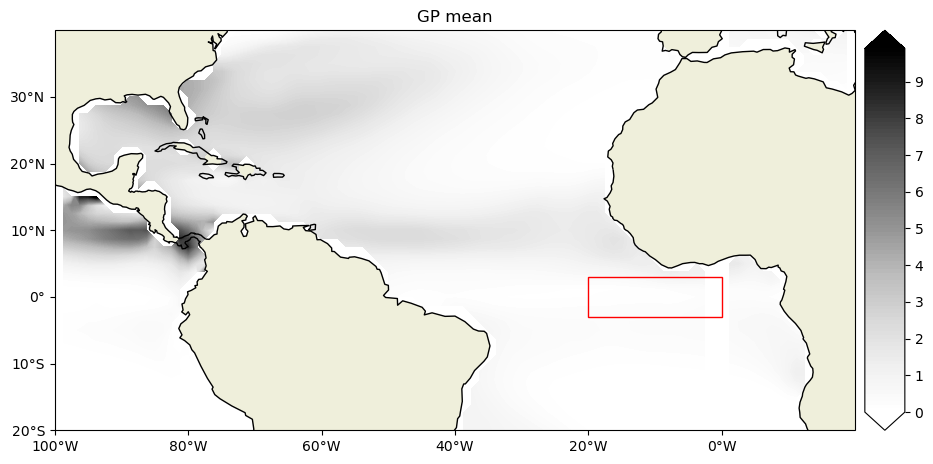

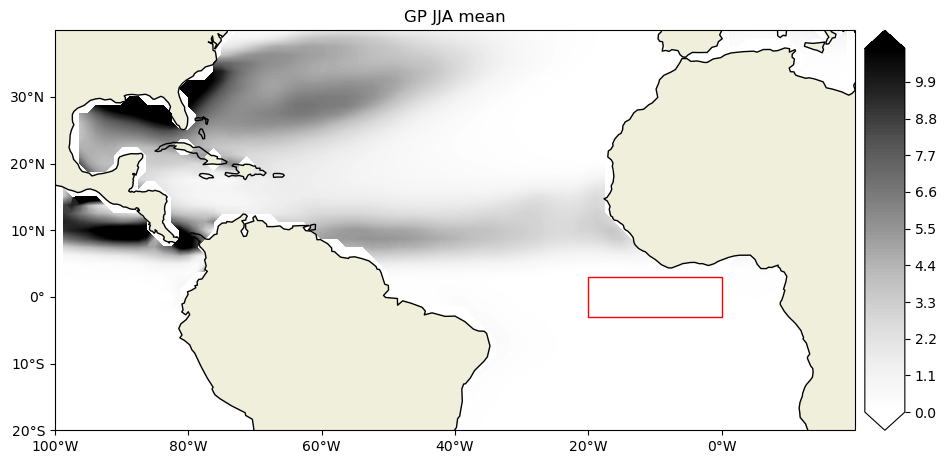

In [58]:
GP_mean = GP.GP.mean('time')
GP_JJA_mean = GP_jja.GP.mean("time") 
AN_map(GP_mean, box, 'GP mean',  lev=np.arange(0, 10, 0.1), color='Greys')
AN_map(GP_JJA_mean, box, 'GP JJA mean', lev=np.arange(0, 11, 0.1), color='Greys')

In [59]:
GP_ANo = GP.GP.sel(time=GP.GP.time.dt.year.isin(ANoy))
GP_ANa = GP.GP.sel(time=GP.GP.time.dt.year.isin(ANay))
GP_ANn = GP.GP.sel(time=GP.GP.time.dt.year.isin(ANny))
GP_ANo_m = GP_ANo.mean('time')
GP_ANa_m = GP_ANa.mean('time')
GP_ANn_m = GP_ANn.mean('time')

In [60]:
ANo_diff = GP_mean - GP_ANo_m
ANa_diff = GP_mean - GP_ANa_m
ANn_diff = GP_mean - GP_ANn_m

phase_diff = GP_ANo_m - GP_ANa_m

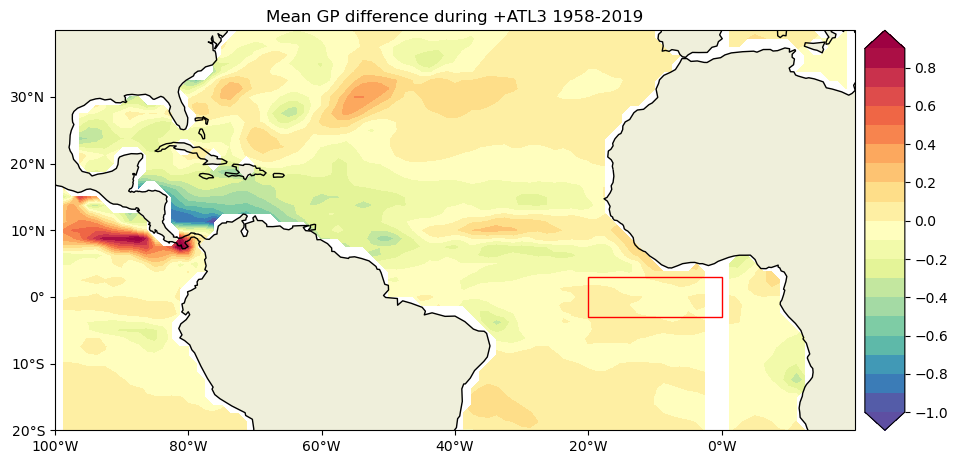

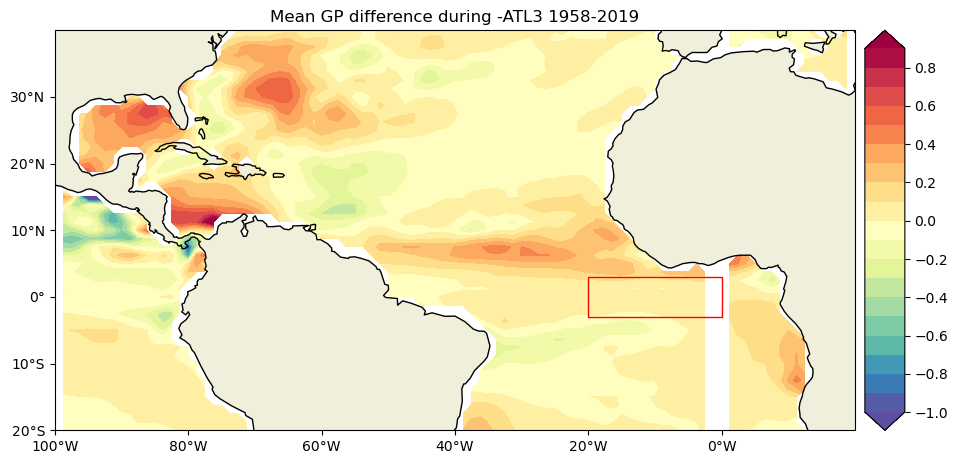

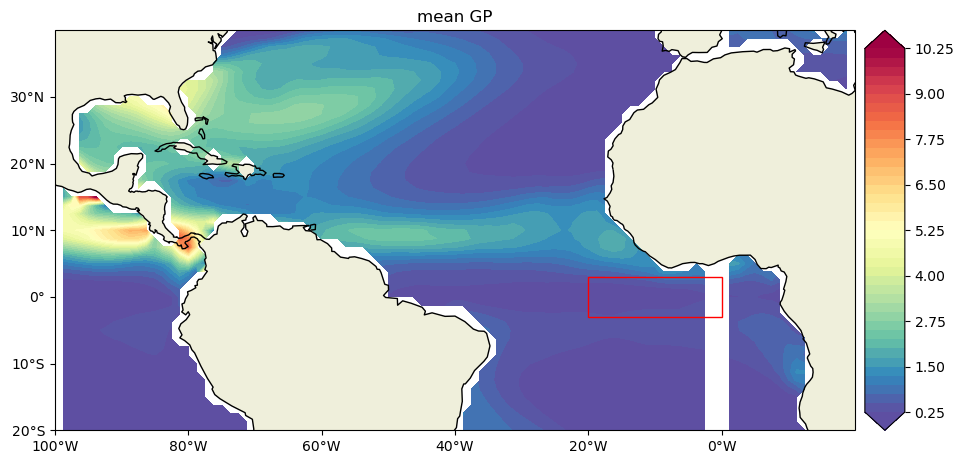

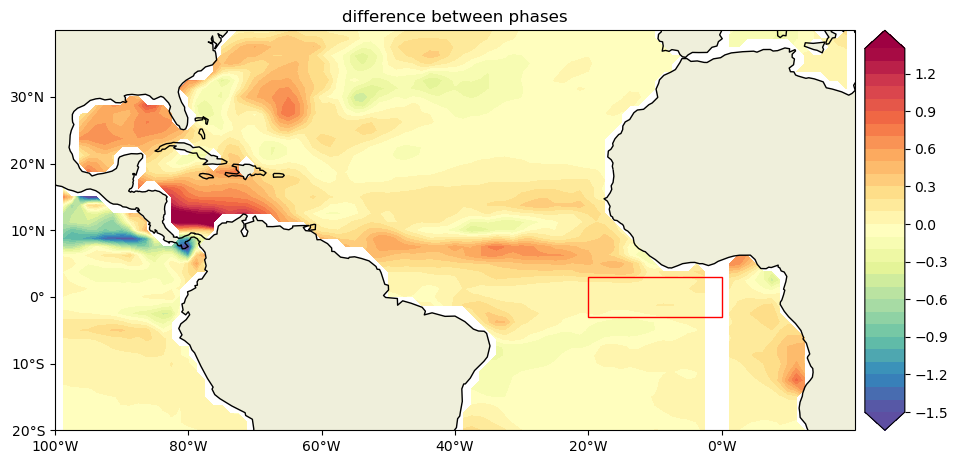

In [61]:
comp_map(ANo_diff, box, "Mean GP difference during +ATL3 1958-2019")
comp_map(ANa_diff, box, "Mean GP difference during -ATL3 1958-2019")
# comp_map(ANn_diff, box, "Mean GP difference during neutral AN 1958-2019")
comp_map(GP_mean, box, 'mean GP', lev=50)
comp_map(phase_diff, box, "difference between phases", lev=np.arange(-1.5, 1.5, 0.1))

### Difference in GP between phases during hurricane seasons

In [62]:
GP_s_ANo = GP_ANo.groupby("time.season").mean("time")
GP_s_ANa = GP_ANa.groupby("time.season").mean('time')
GP_s_mean = GP.GP.groupby("time.season").mean('time')

In [63]:
ANo_MAM = GP_s_ANo.sel(season='MAM')
ANo_JJA = GP_s_ANo.sel(season='JJA')
ANo_SON = GP_s_ANo.sel(season='SON')
ANo_DJF = GP_s_ANo.sel(season='DJF')

GP_m_MAM = GP_s_mean.sel(season='MAM')
GP_m_JJA = GP_s_mean.sel(season='JJA') 
GP_m_SON = GP_s_mean.sel(season='SON') 
GP_m_DJF = GP_s_mean.sel(season='DJF')

def hurricane_season(month):
    return (month >= 5) & (month <= 11)

GP_H = GP.GP.sel(time=hurricane_season(GP.GP['time.month'])).mean('time')
GP_H_ANo = GP_ANo.sel(time=hurricane_season(GP_ANo['time.month'])).mean('time')
GP_H_ANa = GP_ANa.sel(time=hurricane_season(GP_ANa['time.month'])).mean('time')

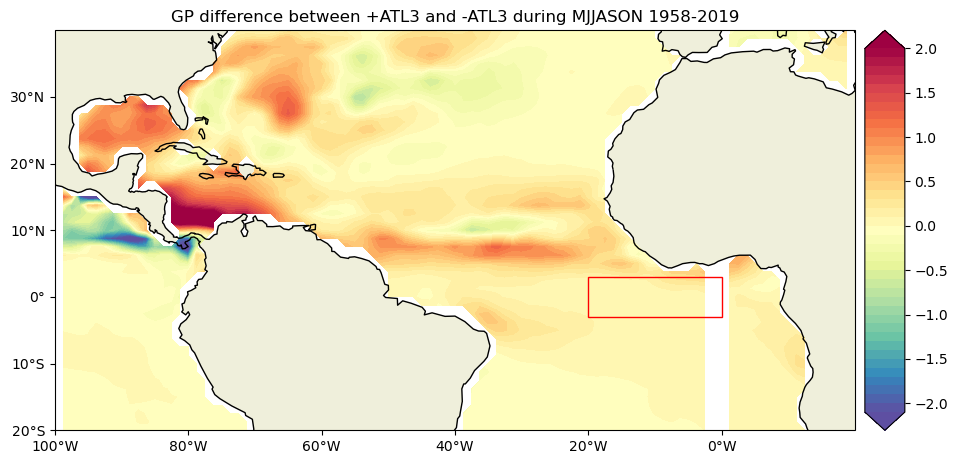

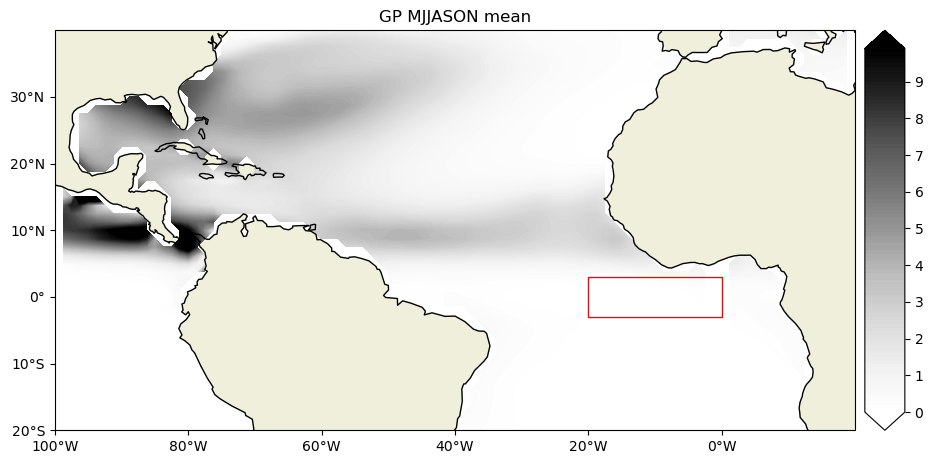

In [64]:
GP_H_AN_diff = GP_H_ANo - GP_H_ANa

comp_map(GP_H_AN_diff, box, "GP difference between +ATL3 and -ATL3 during MJJASON 1958-2019", lev=np.arange(-2.1, 2.1,0.1))
AN_map(GP_H, box, 'GP MJJASON mean', lev=np.arange(0, 10, 0.1), color='Greys')

### 4x4 plots

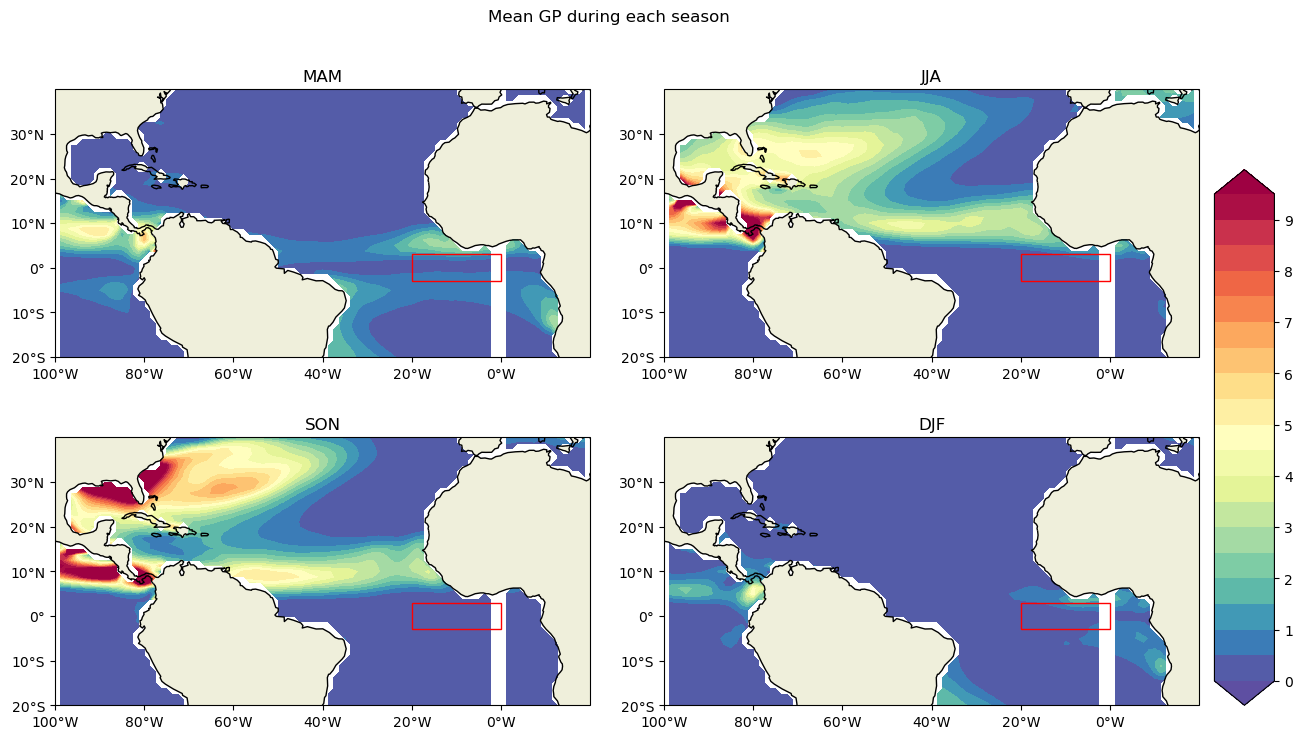

In [65]:
multi_map(GP_m_MAM,
          GP_m_JJA,
          GP_m_SON,
          GP_m_DJF, box, "Mean GP during each season", lev=np.arange(0, 10, 0.5))

In [66]:
ANo_diff_MAM = ANo_MAM - GP_m_MAM
ANo_diff_JJA = ANo_JJA - GP_m_JJA
ANo_diff_SON = ANo_SON - GP_m_SON
ANo_diff_DJF = ANo_DJF - GP_m_DJF

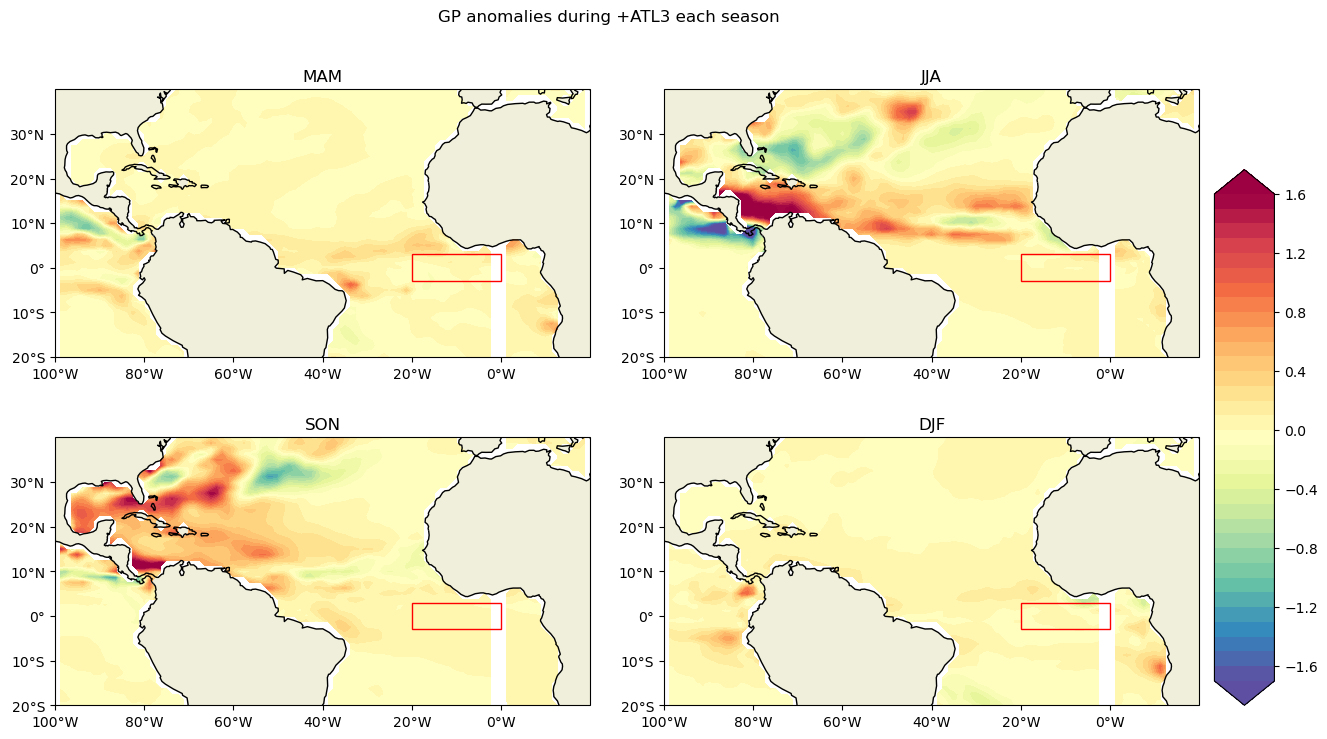

In [67]:
multi_map(ANo_diff_MAM,
          ANo_diff_JJA,
          ANo_diff_SON,
          ANo_diff_DJF, box, "GP anomalies during +ATL3 each season", lev=np.arange(-1.7, 1.7, 0.1))

In [68]:
ANa_MAM = GP_s_ANa.sel(season='MAM')
ANa_JJA = GP_s_ANa.sel(season='JJA')
ANa_SON = GP_s_ANa.sel(season='SON')
ANa_DJF = GP_s_ANa.sel(season='DJF')

In [69]:
ANa_diff_MAM = ANa_MAM - GP_m_MAM
ANa_diff_JJA = ANa_JJA - GP_m_JJA 
ANa_diff_SON = ANa_SON - GP_m_SON
ANa_diff_DJF = ANa_DJF - GP_m_DJF

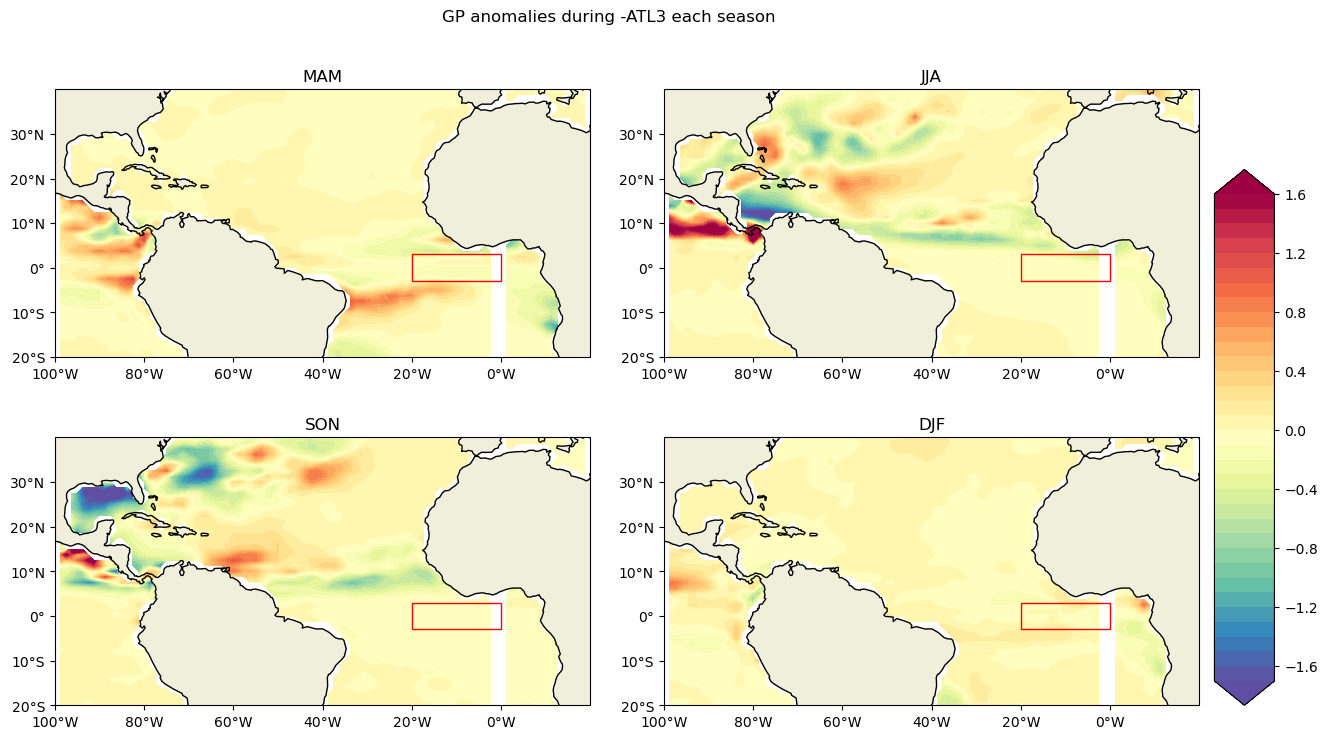

In [70]:
multi_map(ANa_diff_MAM,
          ANa_diff_JJA,
          ANa_diff_SON,
          ANa_diff_DJF, box, "GP anomalies during -ATL3 each season", lev=np.arange(-1.7, 1.7, 0.1))